In [ ]:
import math
import random 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression


%matplotlib inline

In [ ]:
def f(x):
    """
    True function f(x) (unknown to us)
    """
    return 2 * x - 1.4 * x ** 2

  
def generate_data(n):
    """
    Creates and returns a DataFrame with n randomly drawn examples
    """
    xs = [random.uniform(0, 1) for _ in range(n)]   # generate n numbers uniform at random from [0, 1]
    ys = [f(x) + random.gauss(0, 0.1) for x in xs]  # evaluate f at each x and add Gaussian noise (mean=0, variance=.1)
    return pd.DataFrame({'x': xs, 'y': ys})
  
  
def polynomial_features(data, col, target, deg):
    """
    Given a dataset, creates a polynomial expansion of the input with 
    the given name to the given degree. Must also take the target column name.
    
    Returns the dataset and the list of column names
    """
    data_copy = data.copy()
    if deg == 0:
        data_copy[col + '0'] = 1
        columns = [col + '0']
    else:
        columns = []
        for i in range(0, deg + 1): # +1 to include deg
            col_name = col + str(i)
            data_copy[col_name] = data_copy[col] ** i
            columns.append(col_name)
        
    return data_copy, columns

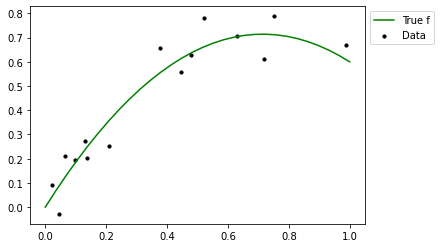

In [ ]:
data = generate_data(15)
plt.scatter(data['x'], data['y'], c='black', s=10, label='Data')

xs = np.linspace(0, 1, 30)
plt.plot(xs, f(xs), color='g', label='True f')

plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [ ]:
data, columns = polynomial_features(data, 'x', 'y', 3)
print(columns)
data

['x0', 'x1', 'x2', 'x3']


,x,y,x0,x1,x2,x3
0,0.631360,0.706486,1.0,0.631360,0.398615,0.251670
1,0.445766,0.558560,1.0,0.445766,0.198708,0.088577
2,0.751277,0.788312,1.0,0.751277,0.564418,0.424034
3,0.986652,0.671044,1.0,0.986652,0.973482,0.960488
4,0.477681,0.629427,1.0,0.477681,0.228179,0.108997
5,0.375646,0.656604,1.0,0.375646,0.141110,0.053007
6,0.717077,0.610305,1.0,0.717077,0.514199,0.368720
7,0.064350,0.210363,1.0,0.064350,0.004141,0.000266
8,0.096614,0.194960,1.0,0.096614,0.009334,0.000902
9,0.522068,0.780023,1.0,0.522068,0.272555,0.142292


In [ ]:
def learn_models(data, features, target):
    """
    Trains num_models models on random subsets of the given data. 
    Returns the list of learned models.
    """
    models = []
    for i in data.index:
        remaining = data.loc[data.index != i, :]
        model = LinearRegression()
        model.fit(remaining[features], remaining[target])
        models.append(model)
    return models

In [ ]:
learn_models(data, columns, 'y')

[LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False),
 LinearRegressio

In [ ]:
def find_predictions_range(models, model_degree, num_eval_points):
    """
    Compares the predictions of the given models at num_eval_points between 0 and 1.
    
    This gives a description of how spread the predictions are at a particular point x. 
    If the predictions are all over the place, then the range of predictions will be high.
    
    Returns:
        * A list of points evaluated (of length num_eval_points)
        * A list of tuples containing information about the predictions at each eval point. 
          Each tuple contains the minimum prediction, mean prediction, and max prediction for that input
          
    """
    new_xs = np.linspace(0, 1, num_eval_points) # just like range, but allows for fractional steps
    new_data = pd.DataFrame({'x': new_xs})
    new_data, columns = polynomial_features(new_data, 'x', 'y', model_degree)

    all_predictions = [model.predict(new_data[columns]) for model in models]
    intervals = []
    for i in range(len(new_xs)):        
        # get predictions from each model for this input i
        preds_i = [preds[i] for preds in all_predictions]
        # find the mean, min, and max
        intervals.append((min(preds_i), np.mean(preds_i), max(preds_i)))
        
    return new_xs, intervals

In [ ]:
def plot(data, new_xs, intervals):
    """
    Plots the data and range of predictions to demonstrate the bias and variance of the model
    """
    # magic to separate list of [(low, mean, high)] to list of lows, list of means, list of highs
    lows, means, highs = zip(*intervals)       
    
    # plot the range bands for predictions
    plt.fill_between(new_xs, lows, highs, facecolor='#E8F8F8', edgecolor='#c3e2e2',
                     label='Range of predictions')
    # plot the average predictions (won't perfectly match f because it's an approximation of E_train[hat{f}]
    plt.plot(new_xs, means, color="r", label='Average hat{f}')
    # plot the true f
    plt.plot(new_xs, [f(x) for x in new_xs], color='g', label='True f')
    # plot the datapoints
    plt.scatter(data['x'], data['y'], c='black', s=10, label='Data')

    # modify axis to make it look nice and add label
    axes = plt.gca()
    axes.set_xlim([0, 1])
    axes.set_ylim([data['y'].min() - 0.5, data['y'].max() + 0.5])
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

Evaluating model with degree 0


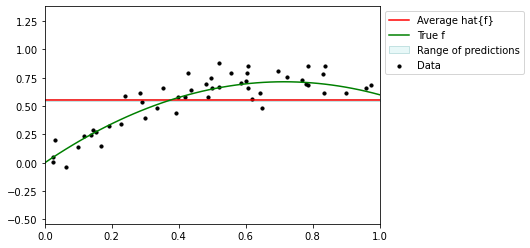

Evaluating model with degree 1


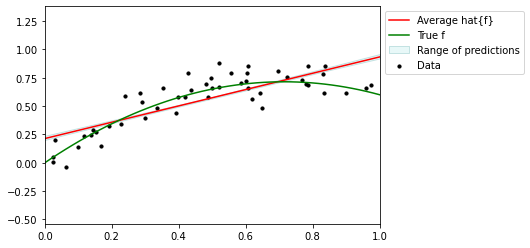

Evaluating model with degree 2


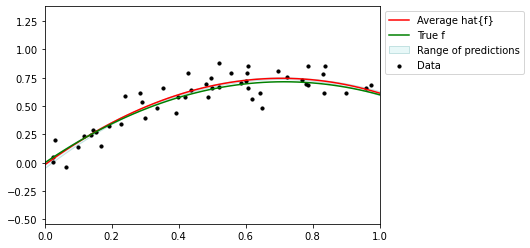

Evaluating model with degree 5


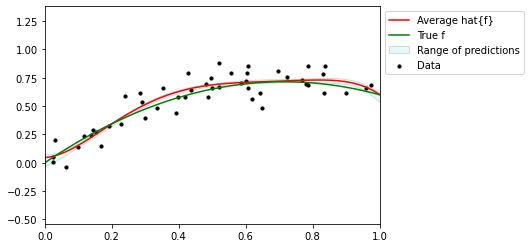

Evaluating model with degree 10


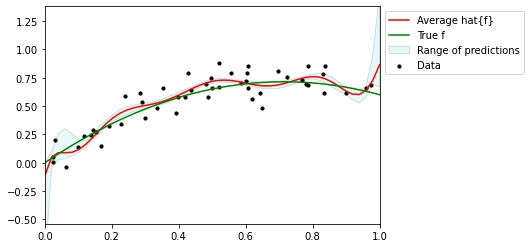

Evaluating model with degree 20


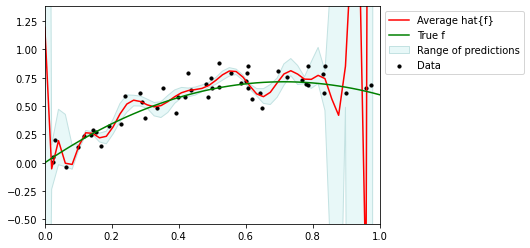

Evaluating model with degree 60


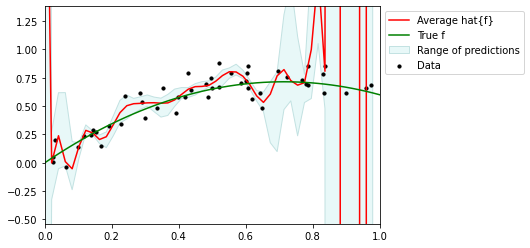

In [ ]:
DEGREES = [0, 1, 2, 5, 10, 20, 60]
data = generate_data(50)
for degree_expansion in DEGREES:
    print('Evaluating model with degree ' + str(degree_expansion))
    # generate data with 
    data, columns = polynomial_features(data, 'x', 'y', degree_expansion)
    models = learn_models(data, columns, 'y')
    new_xs, intervals = find_predictions_range(models, degree_expansion, 50)
    plot(data, new_xs, intervals)

Evaluating model with degree 0


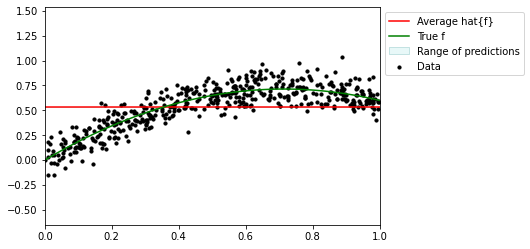

Evaluating model with degree 1


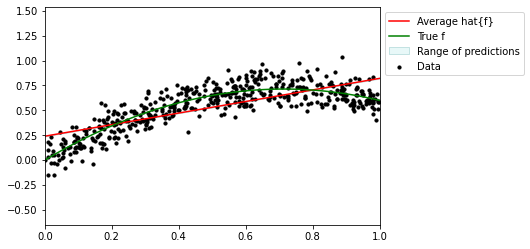

Evaluating model with degree 2


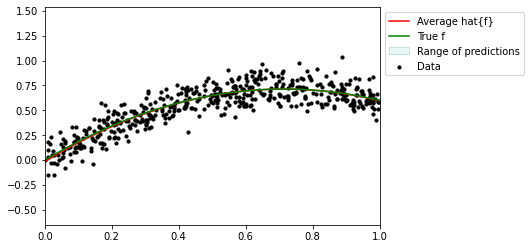

Evaluating model with degree 5


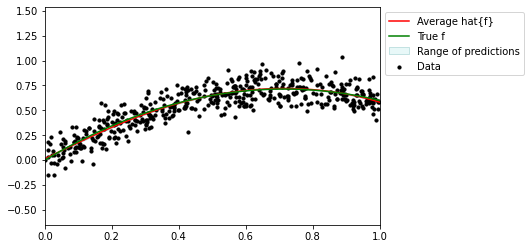

Evaluating model with degree 10


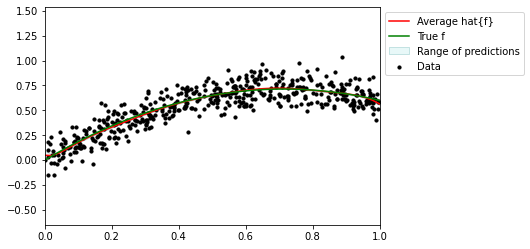

Evaluating model with degree 20


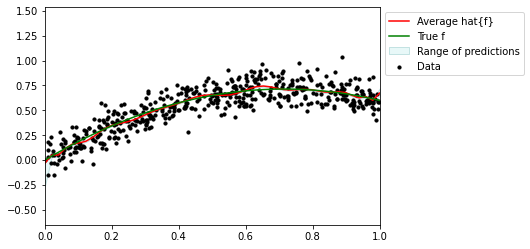

Evaluating model with degree 60


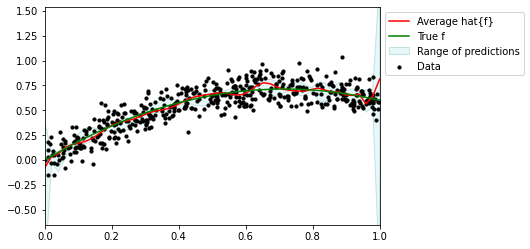

In [ ]:
DEGREES = [0, 1, 2, 5, 10, 20, 60]
data = generate_data(500)
for degree_expansion in DEGREES:
    print('Evaluating model with degree ' + str(degree_expansion))
    # generate data with 
    data, columns = polynomial_features(data, 'x', 'y', degree_expansion)
    models = learn_models(data, columns, 'y')
    new_xs, intervals = find_predictions_range(models, degree_expansion, 50)
    plot(data, new_xs, intervals)